# Дообучение BERT на данных по токсичности (тестирование)

Модель [*rubert-tiny-toxicity*](https://huggingface.co/cointegrated/rubert-tiny-toxicity) была дообучена на новых данных, размеченных по токсичности. Теперь проверим дообученную модель на тестовой выборке, получим метрики, сравним с изначальной моделью.

## Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import os

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, balanced_accuracy_score, accuracy_score

import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy, AUC
import transformers 

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None
rand_state=3208

In [2]:
print('torch version:', torch.__version__)
print('transformers version:', transformers.__version__)

torch version: 1.13.1+cu116
transformers version: 4.26.1


In [3]:
test_data = pd.read_csv('test_dataset.tsv', sep='\t')
test_data = test_data.dropna()

In [4]:
test_data.head()

,text_res,labels,non-toxic,insult,obscenity,threat,dangerous,texts,len
0,Это не первый случай у этого сраного аэрофлота.,[0. 1. 0. 0. 0.],0.00,1.00,0.00,0.00,0.00,это не первый случай у этого сраного аэрофлота,8
1,бля бро изза тя у сотрудника бука ЗП вычтут ((...,[0. 0. 1. 0. 0.],0.00,0.00,1.00,0.00,0.00,бля бро изза тя у сотрудника бука зп вычтут же...,12
2,Знаю про этот случай.. Халатность Аэрофлота 10...,[0. 0. 0. 0. 1.],0.00,0.00,0.00,0.00,1.00,знаю про этот случай халатность аэрофлота хозя...,26
3,Удаленная работа ЗП от 25 до 35 тыс. рублей<br...,[1. 0. 0. 0. 0.],1.00,0.00,0.00,0.00,0.00,удаленная работа зп от до тыс рублей звонки оф...,15
4,!ATTENTION! студенты/мамы в декрет/кому нужны ...,[1. 0. 0. 0. 0.],1.00,0.00,0.00,0.00,0.00,студенты мамы в декрет кому нужны деньги предл...,35


## Загрузка модели

In [5]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny-toxicity")
model_old = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny-toxicity", num_labels=5)

model_path = 'model_toxicity_final'
model_new = BertForSequenceClassification.from_pretrained(model_path, num_labels=5)

In [6]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
    torch.cuda.empty_cache()
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:21,garbage_collection_threshold:0.6"
    cuda_id = torch.cuda.current_device()
    model_old.cuda()
    model_new.cuda()
    
    print('Cuda ON')
    print(f'CUDA version: {torch.version.cuda}')
    print(f'Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}')
    
else:
    print('No Cuda')

Cuda ON
CUDA version: 11.6
Name of current CUDA device: NVIDIA GeForce GT 1030


In [7]:
args = TrainingArguments(
    output_dir = 'output_test',
    per_device_train_batch_size = 3,
    per_device_eval_batch_size = 3,
    seed = rand_state)

old_trainer = Trainer(model = model_old, args = args)
new_trainer = Trainer(model = model_new, args = args)

## Получение предсказаний

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [9]:
def get_probas(ds, trnr):
    pred, _, _ = trnr.predict(ds)
    pred_torch = torch.as_tensor(pred, dtype=torch.float32, device=torch.device('cpu'))    
    test_proba = torch.sigmoid(pred_torch).cpu().numpy()
    result = pd.DataFrame(test_proba, columns=[i for i in cols])
    return result

In [10]:
cols = ['non-toxic', 'insult', 'obscenity', 'threat', 'dangerous']

features_test = list(test_data['texts'])
target_df = test_data[cols]

In [11]:
features_test = tokenizer(features_test, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
test_dataset = Dataset(features_test)

res_old = get_probas(test_dataset, old_trainer)
res_new = get_probas(test_dataset, new_trainer)

***** Running Prediction *****
  Num examples = 13074
  Batch size = 3


***** Running Prediction *****
  Num examples = 13074
  Batch size = 3


## Метрики по категориям токсичности

Посмотрим, как распределяются предсказания моделей по значениям.

Предсказания дообученной модели


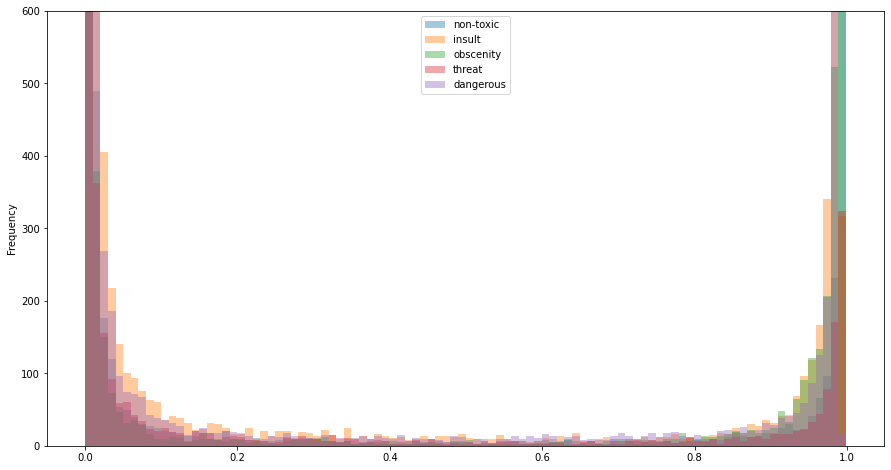

Предсказания изначальной модели


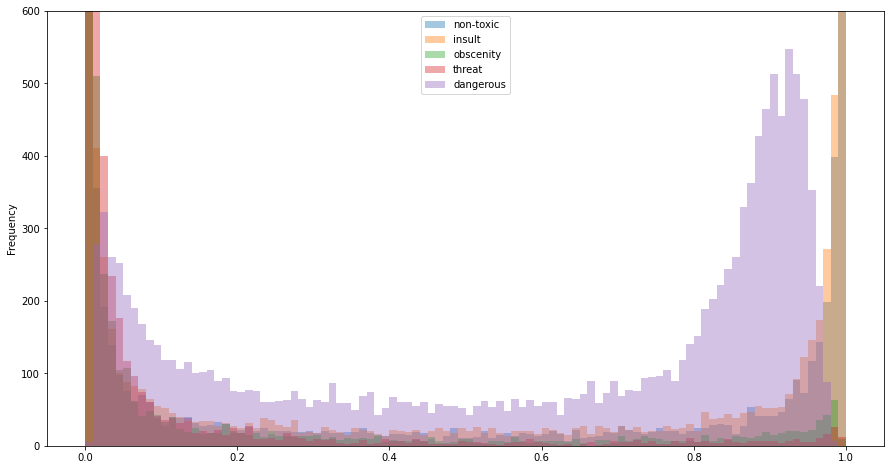

In [12]:
for i in [cols]:
    print('Предсказания дообученной модели')
    res_new[i].plot(kind='hist', figsize=(15, 8), bins=100, alpha=0.4)
    plt.ylim([0.0, 600])
    plt.show()
    print('Предсказания изначальной модели')
    res_old[i].plot(kind='hist', figsize=(15, 8), bins=100, alpha=0.4)
    plt.ylim([0.0, 600])
    plt.show()

Поскольку модель возвращает вероятности меток, вычислим метрики по каждой метке для разных значений threshold. roc_auc вычисляется на основе вероятности, поэтому значение roc_auc будет одно для каждой метки.

In [13]:
def cat_metrics(targ, proba, thr):
    pred = [math.ceil(i-thr) for i in proba]
    roc_auc = roc_auc_score(targ, proba)
    accuracy = balanced_accuracy_score(targ, pred)
    precision = precision_score(targ, pred, average='macro')
    recall = recall_score(targ, pred, average='macro')
    f1 = f1_score(targ, pred, average='macro')
    return [accuracy, precision, recall, f1, roc_auc]

In [14]:
mclist = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metrics_cat = pd.DataFrame()

for threshold in np.linspace(0.1, 0.9, 9):
    table = pd.DataFrame()
    for r, name in zip([res_old, res_new], [' old', ' new']):
        for i in target_df.columns:
            table[i+name]=(cat_metrics(target_df[i], r[i], threshold))
            table.index = [f'{i}_{round(threshold, 2)}' for i in mclist]
    metrics_cat = pd.concat([metrics_cat, table])
metrics_cat = metrics_cat.sort_index()
metrics_cat = metrics_cat.iloc[:37,:]
display(metrics_cat)

,non-toxic old,insult old,obscenity old,threat old,dangerous old,non-toxic new,insult new,obscenity new,threat new,dangerous new
accuracy_0.1,0.78,0.73,0.63,0.55,0.56,0.89,0.83,0.94,0.82,0.75
accuracy_0.2,0.80,0.73,0.60,0.54,0.58,0.88,0.82,0.94,0.81,0.74
accuracy_0.3,0.81,0.73,0.59,0.54,0.59,0.88,0.82,0.93,0.81,0.74
accuracy_0.4,0.81,0.73,0.58,0.54,0.59,0.88,0.81,0.93,0.80,0.73
accuracy_0.5,0.82,0.73,0.57,0.53,0.59,0.88,0.81,0.93,0.79,0.73
accuracy_0.6,0.82,0.73,0.56,0.53,0.58,0.88,0.80,0.93,0.79,0.73
accuracy_0.7,0.83,0.72,0.55,0.53,0.57,0.88,0.80,0.92,0.78,0.71
accuracy_0.8,0.83,0.72,0.54,0.52,0.56,0.87,0.79,0.92,0.78,0.70
accuracy_0.9,0.84,0.71,0.53,0.52,0.53,0.87,0.78,0.90,0.76,0.69
f1_0.1,0.76,0.63,0.65,0.54,0.27,0.89,0.79,0.91,0.74,0.71


**Выводы:**
1. Лучше всего модель обучилась предсказывать категории obscenity и non-toxic (данные по этим меткам представленны наиболее полно). Немного хуже - insult и threat. Хуже всего - dangerous.
2. С увеличением значения threshold также увеличивается precision, а accuracy и recall - уменьшаются.
3. Оптимальным мы будем считать threshold = 0.3 (оптимальный баланс между precision и recall).
4. Дообученная модель показывает лучшие результаты по всем метрикам ('accuracy', 'precision', 'recall', 'f1', 'roc_auc') по сравнению с изначальной моделью. accuracy: 0.74-0.93, f1: 0.72-0.92, precision: 0.7-0.91, recall: 0.74-0.93, roc_auc: 0.86-0.97.

Теперь получим метрики для классификации с несколькими метками. Categorical accuracy, Precision и Recall будем считать для ряда значений threshold. Categorical crossentropy, PR_auc и Roc_auc вычисляются на основе вероятностей, поэтому эти метрики не будут зависеть от threshold.

In [15]:
vals = [sum(target_df[i]) for i in target_df]
vals = np.array(vals)/sum(vals)
vals

array([0.43848289, 0.17597666, 0.21013307, 0.05500605, 0.12040134])

In [16]:
ca = CategoricalAccuracy(name='categorical_accuracy', dtype='float32')
cc = CategoricalCrossentropy(name='categorical_crossentropy', dtype='float32', from_logits=False, label_smoothing=0)
pr = AUC(curve='PR', name='PR', dtype='float32', multi_label=True, num_labels=5, label_weights=vals, from_logits=False)

def multi_metrics(targ, proba, thr):
    ca.reset_state()
    cc.reset_state()
    pr.reset_state()
    
    cc_score = cc(targ, proba).numpy()
    pr_score = pr(targ, proba).numpy()
    auc_score = roc_auc_score(targ, proba, average='weighted')

    pred = [[math.ceil(j-thr) for j in i] for i in np.array(proba)]
    pred = pd.DataFrame(pred, columns=proba.columns)
    
    ca_score = ca(targ, pred).numpy()
    pre_score = precision_score(targ, pred, labels=[0, 1], average='weighted')
    rec_score = recall_score(targ, pred, labels=[0, 1], average='weighted')
       
    return [cc_score, pr_score, auc_score, ca_score, pre_score, rec_score]

In [17]:
mlist=['Categorical crossentropy', 'PR_auc', 'Roc_auc', 'Categorical accuracy', 'Precision', 'Recall']
multi_m_table = pd.DataFrame()

for r, name in zip([res_old, res_new], [' old', ' new']):
    for threshold in np.linspace(0.1, 0.9, 9):
        multi_m_table[str(round(threshold, 2))+name]=(multi_metrics(target_df, r, threshold))
    
multi_m_table.index=mlist
multi_m_table

,0.1 old,0.2 old,0.3 old,0.4 old,0.5 old,0.6 old,0.7 old,0.8 old,0.9 old,0.1 new,0.2 new,0.3 new,0.4 new,0.5 new,0.6 new,0.7 new,0.8 new,0.9 new
Categorical crossentropy,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,2.07,1.07,1.07,1.07,1.07,1.07,1.07,1.07,1.07,1.07
PR_auc,0.59,0.59,0.59,0.59,0.59,0.59,0.59,0.59,0.59,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81
Roc_auc,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.84,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94
Categorical accuracy,0.58,0.59,0.59,0.59,0.59,0.60,0.60,0.60,0.59,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76
Precision,0.58,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.68,0.82,0.83,0.84,0.85,0.85,0.86,0.86,0.87,0.88
Recall,0.92,0.91,0.90,0.89,0.88,0.87,0.86,0.85,0.82,0.83,0.81,0.80,0.79,0.78,0.77,0.76,0.75,0.73


**Выводы:**

1. Дообученная модель показывает лучшие результаты по сравнению с изначальной по всем метрикам, кроме Recall:
   * Categorical crossentropy - 1.7, почти в два раза меньше;
   * PR_auc - 0.81, больше на 0.22;
   * Roc_auc - 0.94, болше на 0.1;
   * Categorical accuracy - 0.76, разница от 0.16 и более;
   * Precision - 0.82-0.88, разница от 0.2 и более. Для threshold=0.3 имеем Precision=0.84;
   * Recall - показывает результаты хуже, 0.73-0.81, разница до 0.1. Для threshold=0.3 имеем Recall=0.8.

## Графики ROC-AUC и Precision/Recall

Построим графики ROC-AUC и Precision/Recall.

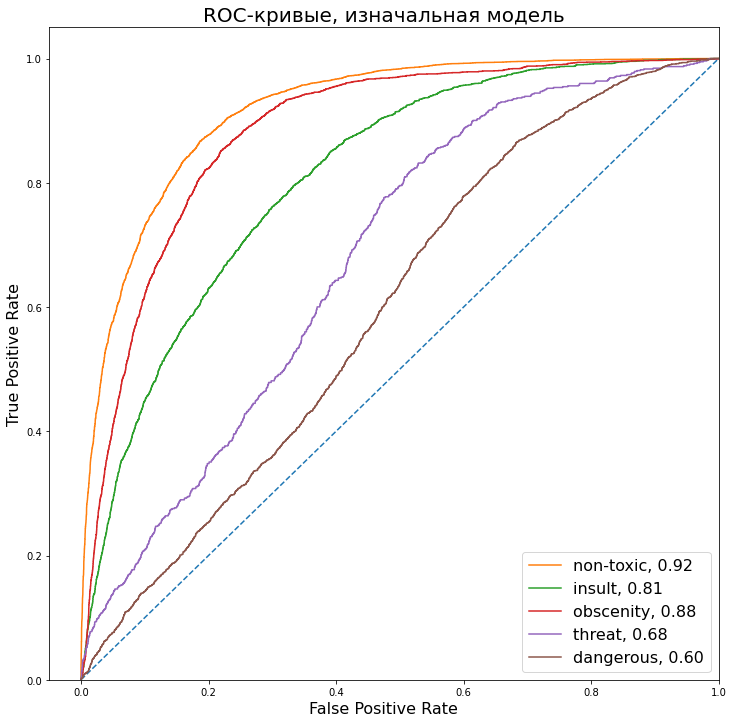

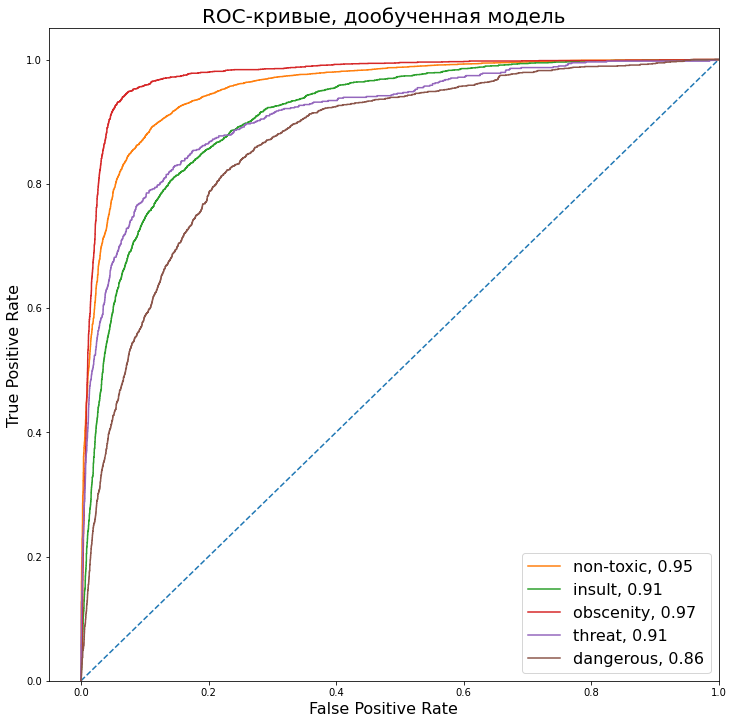

In [18]:
for res, name, aucs in zip([res_old, res_new], ['изначальная модель', 'дообученная модель'], [metrics_cat.iloc[-1, :5],
                                                                            metrics_cat.iloc[-1, 5:]]):
    plt.figure(figsize=(12, 12))
    plt.plot([0, 1], [0, 1], linestyle='--')

    for i, j in zip(target_df.columns, aucs):
        fpr, tpr, thr = roc_curve(target_df[i], res[i])
        plt.plot(fpr, tpr, label='{}, {:.2f}'.format(i, j))

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([-0.05, 1.0])
    plt.title(f'ROC-кривые, {name}', fontsize=20)
    plt.legend(loc = 'lower right', fontsize=16)
    plt.show()

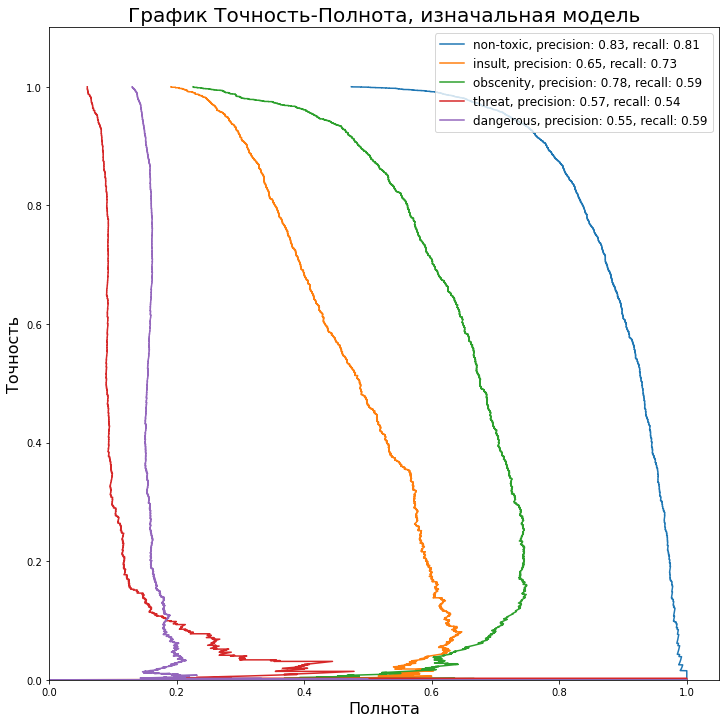

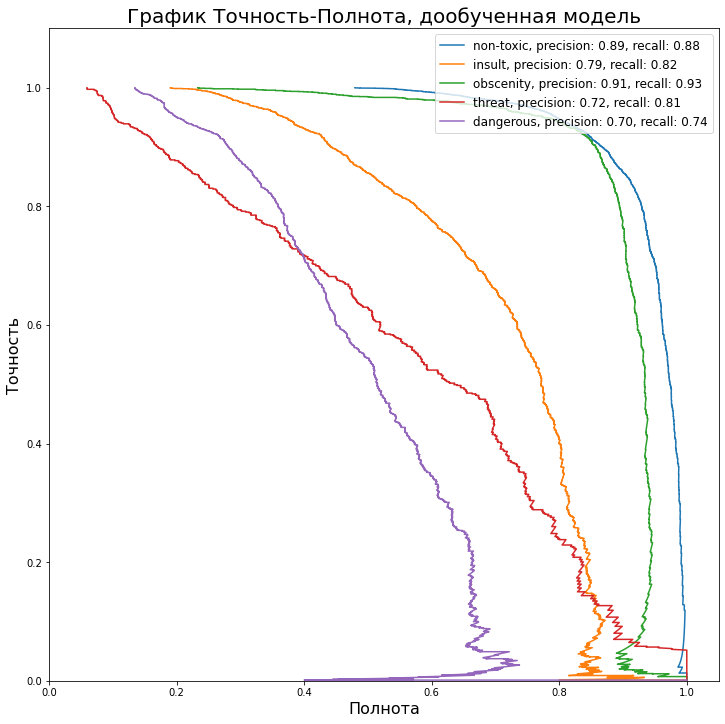

In [19]:
prsc = metrics_cat.loc[(metrics_cat.index=='precision_0.3') | (metrics_cat.index=='recall_0.3')]

for res, name, prs in zip([res_old, res_new], ['изначальная модель', 'дообученная модель'],
                          [np.array(prsc.iloc[:,:5].T), np.array(prsc.iloc[:,5:].T)]):
    plt.figure(figsize=(12, 12))

    for i, j in zip(target_df.columns, prs):
        pre, rec, trh_pr = precision_recall_curve(target_df[i], res[i])
        plt.plot(pre, rec, label='{}, precision: {:.2f}, recall: {:.2f}'.format(i, j[0], j[1]))

    plt.xlabel('Полнота', fontsize=16)
    plt.ylabel('Точность', fontsize=16)
    plt.ylim([0.0, 1.1])
    plt.xlim([0, 1.05])
    plt.title(f'График Точность-Полнота, {name}', fontsize=20)
    plt.legend(loc = 'upper right', fontsize=12)
    plt.show()

**Выводы:**

1. По графикам видно, что дообученная модель показывает лучшие характеристики в плане TPR/FPR, а также в плане соотношения Precision/Recall.
2. По графику ROC-AUC также можно заметить, что для threshold значение 0.3 является оптимальным для всех меток. Хотя некоторые метки, например obscenity, допускают и меньшее значение threshold.
3. Также видно, что категория dangerous обучилась хуже всего. А non-toxic и obscenity - лучше всего.

## Метрики по аггрегированной токсичности

Посмотрим, как модель справится с задачей, если понадобится общая характеристика по токсичности, без категоризации. Будем считать, что если хотя бы одна из категорий получает значение больше threshold, то токсичность есть. В противном случае, её нет.

Рассчитаем метрики по общей токсичности для различных значений threshold.

In [20]:
def aggregate(data, thr):
    agg_data = [1 if max(i) > thr else 0 for i in np.array(data.iloc[:, 1:5])]
    return pd.Series(agg_data)

In [21]:
def cat_metrics_agg(targ, proba):
    roc_auc = roc_auc_score(targ, proba)
    accuracy = accuracy_score(targ, proba)
    precision = precision_score(targ, proba)
    recall = recall_score(targ, proba)
    f1 = f1_score(targ, proba)
    return [accuracy, precision, recall, f1, roc_auc]

In [22]:
agg_table = pd.DataFrame(index=mclist)

for r, name in zip([res_old, res_new], [' old', ' new']):
    for threshold in np.linspace(0.1, 0.9, 9):
        agg_table[str(round(threshold, 2))+name]=(cat_metrics_agg(
            aggregate(target_df, threshold),
            aggregate(r, threshold)
        ))
agg_table

,0.1 old,0.2 old,0.3 old,0.4 old,0.5 old,0.6 old,0.7 old,0.8 old,0.9 old,0.1 new,0.2 new,0.3 new,0.4 new,0.5 new,0.6 new,0.7 new,0.8 new,0.9 new
accuracy,0.66,0.72,0.75,0.77,0.79,0.81,0.82,0.82,0.79,0.88,0.88,0.88,0.88,0.88,0.88,0.87,0.87,0.86
precision,0.61,0.66,0.69,0.72,0.75,0.78,0.82,0.86,0.92,0.84,0.85,0.85,0.86,0.87,0.87,0.88,0.88,0.90
recall,0.98,0.96,0.94,0.92,0.90,0.87,0.84,0.79,0.66,0.95,0.94,0.94,0.93,0.92,0.90,0.89,0.86,0.82
f1,0.75,0.78,0.80,0.81,0.82,0.83,0.83,0.82,0.77,0.89,0.89,0.89,0.89,0.89,0.89,0.88,0.87,0.86
roc_auc,0.64,0.70,0.74,0.76,0.79,0.80,0.82,0.82,0.80,0.87,0.87,0.88,0.88,0.88,0.88,0.87,0.87,0.86


**Выводы:**

1. Дообученная модель показывает лучшие результаты по сравнению с изначальной по всем метрикам. Для threshold=0.3:
   * accuracy = 0.88;
   * precision = 0.85;
   * recall = 0.94 (такое же, как и у изначальной модели);
   * f1 = 0.89;
   * roc_auc = 0.88.

## Визуализация

Посмотрим, как дообученная модель работает на конкретных примерах. Будем считать, что если хотя бы одна из категорий (кроме категории "Не токсично") получает значение больше threshold, то текст токсичен. Исходим из того, что метка "threat" соответствует двум меткам в исходных данных - "Угроза" и "Дискриминация".

In [23]:
def get_toxicity(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model_new.device)
        proba = torch.sigmoid(model_new(**inputs).logits).cpu().numpy()
    return np.around(proba[0], decimals=3)

In [24]:
vals_rus = ['Не токсично', 'Оскорбление', 'Мат/нецензурное', 'Угроза\nДискриминация', 'Грубое высказывание']
thrs = 30

def toxicity_visual(text):
    test = pd.Series(get_toxicity(text)*100, index=cols)

    fig, ax = plt.subplots(figsize=(10, 6))
    test.plot.bar(ax=ax)
    plt.axhline(y=thrs, linestyle='--', color='r')
    ax.xaxis.set_ticklabels(vals_rus, fontsize=12)
    ax.set_ylabel('Вероятность, %', fontsize=16);
    plt.ylim([0, 110])

    rects = ax.patches
    labels = test.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+1, round(label, 1), ha="center", va="bottom", fontsize=12)
    plt.show

    print(f'Текст: "{text}"')
    
    flag = ''
    if max(test[1:])>thrs:
        flag='есть'
    elif test[0]>thrs:
        flag='нет'
    elif max(test)<thrs:
        flag='не понятно'
    print(f'Токсичность: {flag}')

Текст: "ебать ты лох"
Токсичность: есть


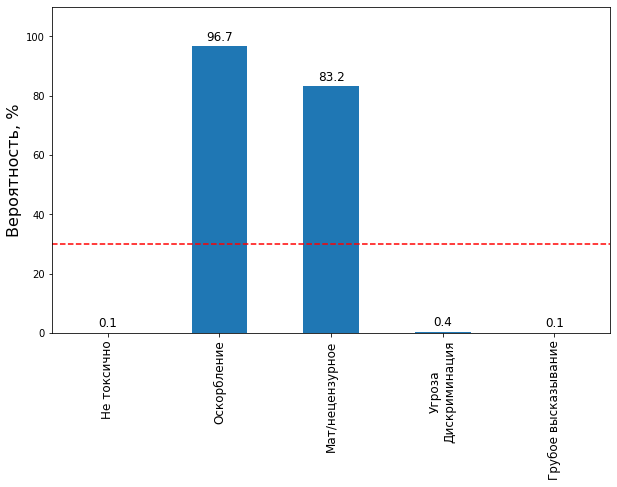

In [25]:
toxicity_visual('ебать ты лох')

Текст: "они достали уже"
Токсичность: есть


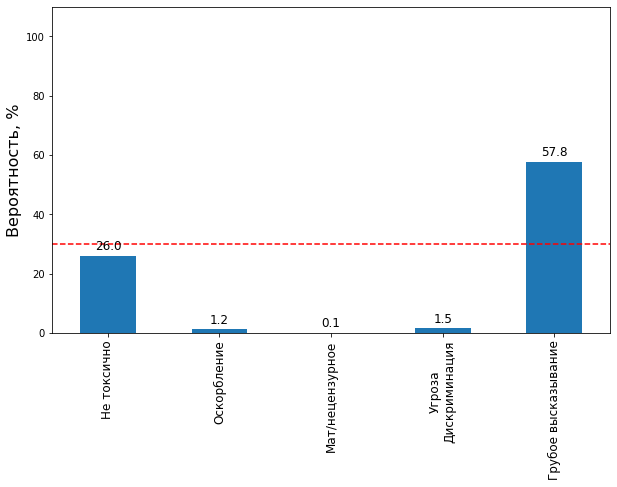

In [26]:
toxicity_visual('они достали уже')

Текст: "камбербэтч ты недоделанный"
Токсичность: есть


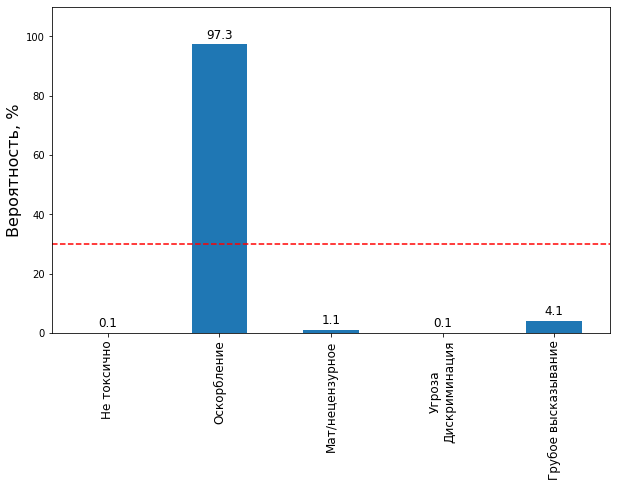

In [27]:
toxicity_visual('камбербэтч ты недоделанный')

Текст: "я их на хую вертел"
Токсичность: есть


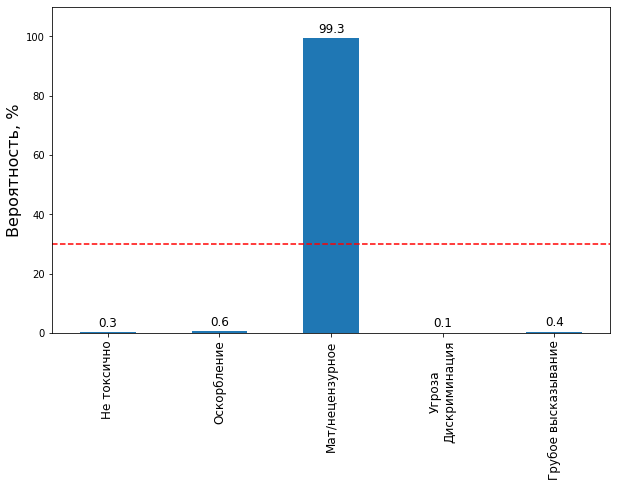

In [28]:
toxicity_visual('я их на хую вертел')

Текст: "дать бы тебе по башке"
Токсичность: есть


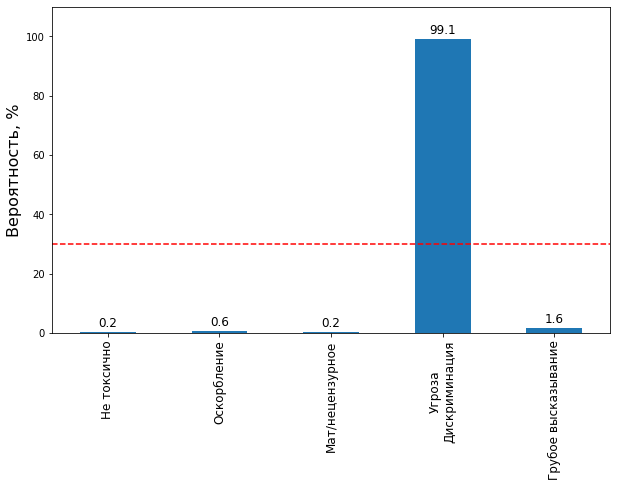

In [29]:
toxicity_visual('дать бы тебе по башке')

Текст: "привет, как дела"
Токсичность: нет


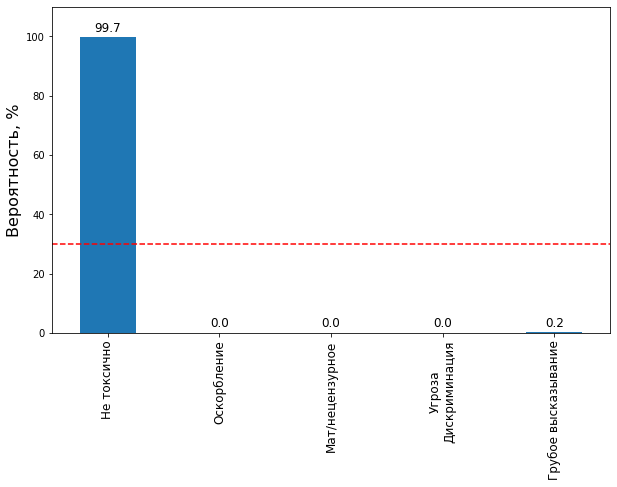

In [30]:
toxicity_visual('привет, как дела')

Текст: "они погрязли в своем дебилизме"
Токсичность: есть


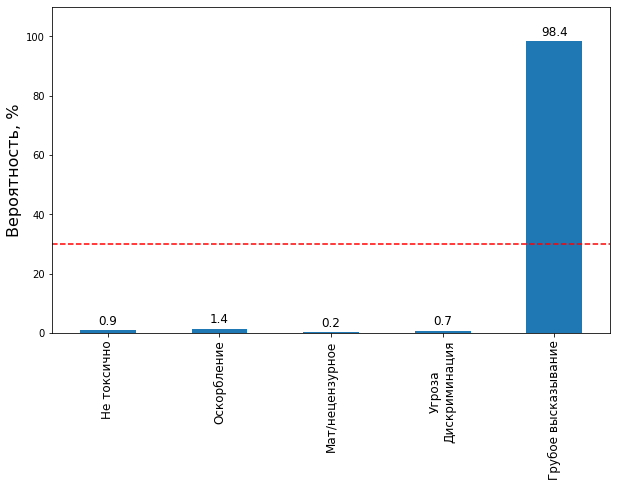

In [31]:
toxicity_visual('они погрязли в своем дебилизме')

Текст: "я тебя найду и въебу"
Токсичность: есть


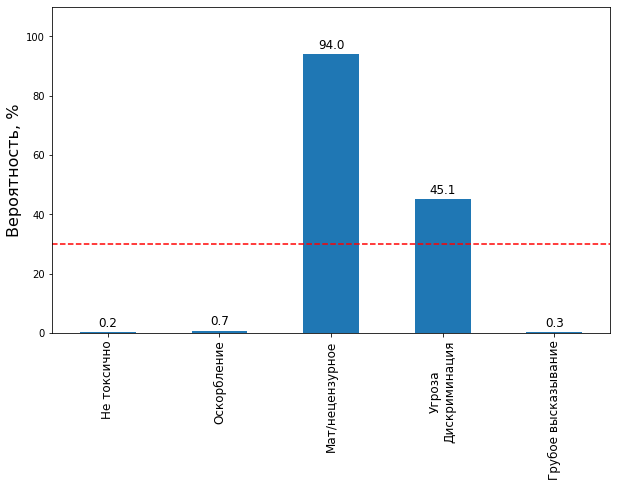

In [32]:
toxicity_visual('я тебя найду и въебу')

Текст: "я тя щас убью"
Токсичность: есть


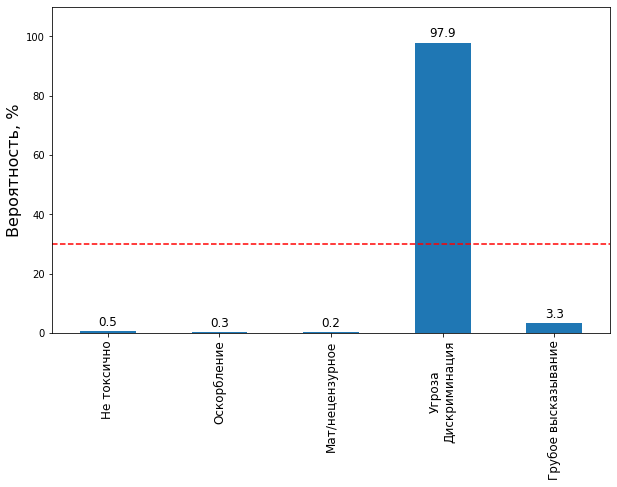

In [33]:
toxicity_visual('я тя щас убью')

Текст: "чертовы нигры"
Токсичность: есть


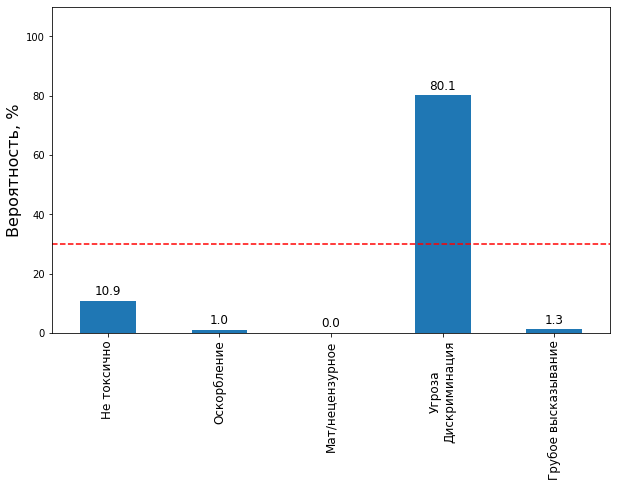

In [34]:
toxicity_visual('чертовы нигры')

Текст: "чурки понаехавшие"
Токсичность: есть


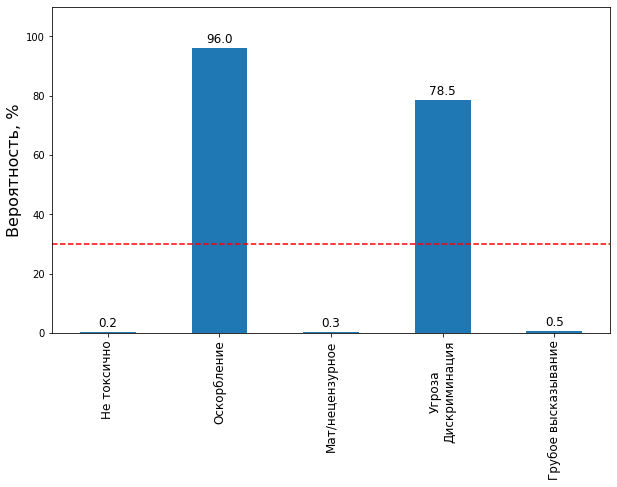

In [35]:
toxicity_visual('чурки понаехавшие')

Текст: "этот гребаный понедельник меня достал"
Токсичность: есть


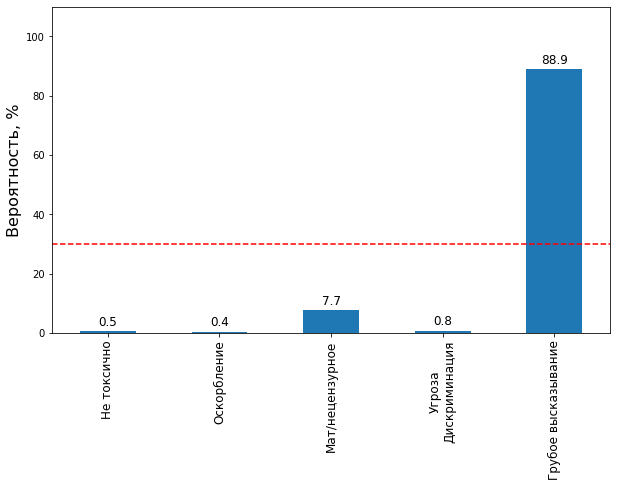

In [36]:
toxicity_visual('этот гребаный понедельник меня достал')

Текст: "ебушки-воробушки"
Токсичность: есть


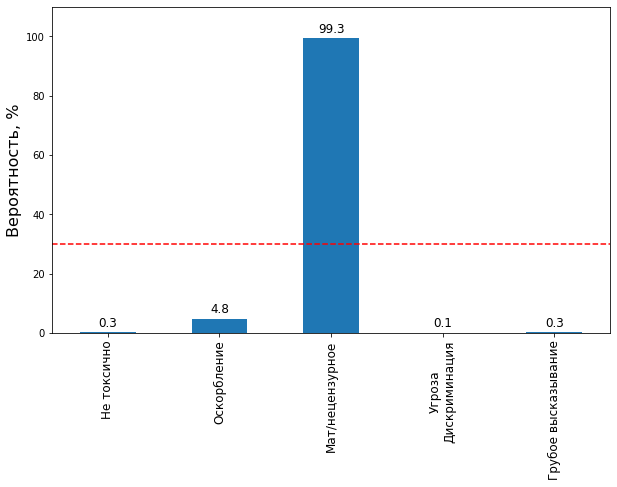

In [37]:
toxicity_visual('ебушки-воробушки')

Текст: "Джей и Молчаливый Боб терпимы в малых дозах, если вообще терпимы. Целого фильма они не заслуживают"
Токсичность: нет


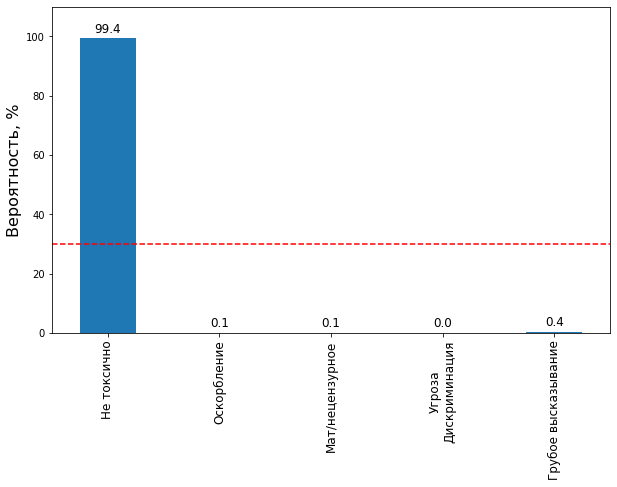

In [38]:
toxicity_visual('Джей и Молчаливый Боб терпимы в малых дозах, если вообще терпимы. Целого фильма они не заслуживают')